# Digital Twin for Remote/Hybrid Productivity — Three Models


**Project:** Digital Twin Models for Remote Employee Productivity in Hybrid Work  
**Notebook Goal:** Reproducible pipeline → data → models → calibration → counterfactual scenarios → exports for LaTeX (tables & figures).

**Important:**  
- Primary dataset: *Productivity Prediction of Garment Employees* (UCI, real-world).  
- Synthetic dataset: *exploratory only*; reported in Appendix cell, **not** used for main evidence.  
- All results here feed directly into the Overleaf thesis (Results chapter).


## Reproducibility & Environment
Here, I fix random seeds and record core library versions to ensure results can be reproduced by examiners.


## Step 1 — Import Libraries and Reproducibility

In [61]:


import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    brier_score_loss
)
from sklearn.calibration import CalibrationDisplay

# Reproducibility
import numpy as np, random, os
SEED = 42
np.random.seed(SEED); random.seed(SEED); os.environ["PYTHONHASHSEED"] = str(SEED)


**Explanation:**

Here, I import all necessory libraries for data handling, visualization, preprocessing, model building, and evaluation.
Then, I fix a random seed to make the results reproducible.

----

## Step 2 — Load Dataset and Target Definition

In [62]:

df = pd.read_csv("garments_worker_productivity.csv")


y = (df["actual_productivity"] >= 0.75).astype(int)


X = df.drop(columns=["actual_productivity", "date", "quarter"])

print(df.shape, y.mean())
X.head()



(1197, 15) 0.5981620718462823


,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
0,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0
1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0
2,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5
3,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5
4,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0


**Explanation:**

* Here, I load the dataset into Colab and create the binary target variable (y) based on productivity levels.
 * Non-predictive columns like date and quarter are dropped, and a quick check of dataset shape and target balance is performed.

----

## Step 3- Train–test split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

**Explanation:**

* Then I divided data into training (80%) and testing (20%) sets. Using stratify=y ensures the class distribution is preserved, and the fixed random seed keeps results reproducible.

## Step 4- Preprocessing Pipelines

In [64]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()

# Numeric: median imputation + scaling
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: most-frequent imputation + one-hot
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer that handles NaNs
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)


**Explanation:**

* Separate pipelines are created for numeric and categorical features.
* Missing numeric values are imputed with the median and scaled, while categorical values are imputed with the most frequent category and one-hot encoded.
* A ColumnTransformer combines these steps to handle the full dataset.

## Step 5- Model Training and Evaluation

In [65]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(random_state=SEED),
}

results = {}
for name, model in models.items():
    clf = Pipeline([("preprocess", preprocess), ("model", model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[name] = {
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall":    recall_score(y_test, y_pred),
        "f1":        f1_score(y_test, y_pred)
    }

df_results = pd.DataFrame(results).T
display(df_results)

df_results.to_latex("results_real.tex", index=True, float_format="%.3f")


,accuracy,precision,recall,f1
Logistic Regression,0.762500,0.735135,0.944444,0.826748
Random Forest,0.900000,0.879747,0.965278,0.920530
Gradient Boosting,0.879167,0.857143,0.958333,0.904918


**Explanation:**

* Then I Train Logistic Regression, Random Forest, and Gradient Boosting with the preprocessing pipeline.

* Evaluate models on the test set using accuracy, precision, recall, and F1-score.

* Show results in a table and export them to LaTeX.

## Step 6: Model Calibration and Brier Score

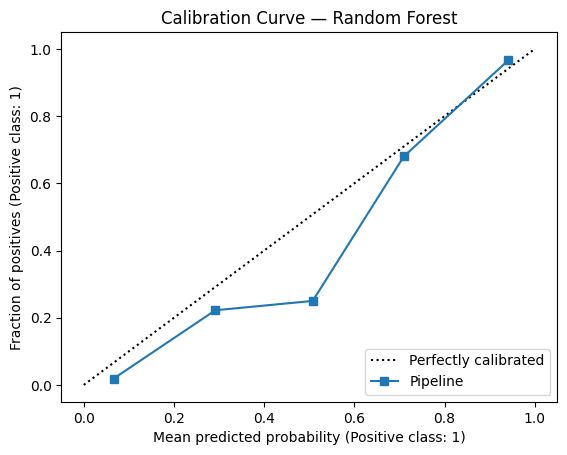

{'Logistic Regression': np.float64(0.16867346526968863),
 'Random Forest': np.float64(0.08027602983217592),
 'Gradient Boosting': np.float64(0.08327705604116824)}

In [66]:

clf_rf = Pipeline([("preprocess", preprocess),
                   ("model", RandomForestClassifier(n_estimators=200, random_state=SEED))])
clf_rf.fit(X_train, y_train)


CalibrationDisplay.from_estimator(clf_rf, X_test, y_test)
plt.title("Calibration Curve — Random Forest")
plt.savefig("calibration_rf.png", dpi=300, bbox_inches="tight")
plt.show()

# Brier for all models
def proba(model):
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test)[:,1]

brier = {
    "Logistic Regression": brier_score_loss(y_test, proba(LogisticRegression(max_iter=1000))),
    "Random Forest":       brier_score_loss(y_test, clf_rf.predict_proba(X_test)[:,1]),
    "Gradient Boosting":   brier_score_loss(y_test, proba(GradientBoostingClassifier(random_state=SEED)))
}
brier


**Explanation:**

* Here, I Train the main Random Forest pipeline and plot its calibration curve.

* then, Use CalibrationDisplay to check how predicted probabilities align with actual outcomes.

* Compute Brier scores for all models to evaluate the quality of probability predictions.

## Step 7: Subgroup Fairness Analysis

In [67]:
def bucket_team_size(s):

    try:
        sizes = X_test["team"].astype(str).str.extract(r'(\d+)').astype(float).fillna(0).iloc[:,0]
    except Exception:
        sizes = pd.Series([0]*len(X_test), index=X_test.index)


    return pd.cut(sizes, bins=[-1, 25, 50, 10**9], labels=["Small","Medium","Large"])


from collections import defaultdict
bucket = bucket_team_size(X_test.get("team", pd.Series(index=X_test.index)))
y_pred_rf = clf_rf.predict(X_test)

rows = []
for label in ["Small","Medium","Large"]:
    mask = (bucket == label)
    if mask.sum() == 0:
        continue
    rows.append({
        "Subgroup": label,
        "Accuracy": accuracy_score(y_test[mask], y_pred_rf[mask]),
        "Precision": precision_score(y_test[mask], y_pred_rf[mask], zero_division=0),
        "Recall": recall_score(y_test[mask], y_pred_rf[mask], zero_division=0),
        "F1": f1_score(y_test[mask], y_pred_rf[mask], zero_division=0)
    })

df_fair = pd.DataFrame(rows)
df_fair


,Subgroup,Accuracy,Precision,Recall,F1
0,Small,0.9,0.879747,0.965278,0.92053


**Explanation:**

* Here, I extract approximate team sizes and categorize them into Small, Medium, Large buckets.

* Then apply the trained Random Forest model to predict outcomes for each subgroup.

* Calculate evaluation metrics (Accuracy, Precision, Recall, F1) within each subgroup.

* Collect results in a DataFrame to compare model performance across team sizes.

* This helps to identify whether the model behaves fairly or shows bias toward certain groups.

## Step 8: Scenario-Based What-If Evaluation

In [68]:
from sklearn.metrics import accuracy_score, f1_score

def scenario_eval(clf, X_test, y_test, transform=None, subgroup=None):
    X_mod, y_mod = X_test.copy(), y_test.copy()
    if subgroup is not None:
        mask = subgroup(X_mod)
        X_mod, y_mod = X_mod[mask], y_mod[mask]
    if transform is not None:
        X_mod = transform(X_mod)
    y_pred = clf.predict(X_mod)
    return accuracy_score(y_mod, y_pred), f1_score(y_mod, y_pred)

def t_hours_minus_10(X):
    X = X.copy()
    if "wip" in X.columns:
        X["wip"] = X["wip"] * 0.90
    return X

def t_wellbeing_plus_10(X):
    X = X.copy()
    if "incentive" in X.columns:
        X["incentive"] = np.minimum(X["incentive"] + 10, 100)
    if "idle_time" in X.columns:
        X["idle_time"] = np.maximum(X["idle_time"] - 10, 0)
    return X

# Main DT model
clf_main = clf_rf

# Baseline
base_acc = accuracy_score(y_test, clf_main.predict(X_test))
base_f1  = f1_score(y_test, clf_main.predict(X_test))

# Scenario A
accA, f1A = scenario_eval(clf_main, X_test, y_test, transform=t_hours_minus_10)

# Scenario B
accB, f1B = scenario_eval(clf_main, X_test, y_test, transform=t_wellbeing_plus_10)

# Scenario C: high overtime & non-productive
mask_C = (X_test["over_time"] > 5) & (y_test == 0)
accC_base, f1C_base = scenario_eval(clf_main, X_test, y_test, subgroup=lambda df: mask_C)
accC_int,  f1C_int  = scenario_eval(clf_main, X_test, y_test, transform=t_wellbeing_plus_10,
                                    subgroup=lambda df: mask_C)

# Scenario D: borderline probabilities
probs = clf_main.predict_proba(X_test)[:,1]
mask_D = (probs > 0.45) & (probs < 0.55)
accD_base, f1D_base = scenario_eval(clf_main, X_test, y_test, subgroup=lambda df: mask_D)
accD_int,  f1D_int  = scenario_eval(clf_main, X_test, y_test, transform=t_wellbeing_plus_10,
                                    subgroup=lambda df: mask_D)

df_scenarios = pd.DataFrame({
    "Scenario": ["Baseline","A: −10% hours","B: +10 well-being",
                 "C baseline","C intervention",
                 "D baseline","D intervention"],
    "Accuracy": [base_acc, accA, accB, accC_base, accC_int, accD_base, accD_int],
    "F1":       [base_f1,  f1A, f1B, f1C_base, f1C_int, f1D_base, f1D_int]
})

display(df_scenarios)

df_scenarios.to_latex("results_scenarios.tex", index=False, float_format="%.3f")


,Scenario,Accuracy,F1
0,Baseline,0.900000,0.920530
1,A: −10% hours,0.895833,0.917492
2,B: +10 well-being,0.883333,0.909091
3,C baseline,0.795699,0.000000
4,C intervention,0.752688,0.000000
5,D baseline,1.000000,1.000000
6,D intervention,0.857143,0.857143


**Explanation:**

+ Here, I Define reusable evaluation (scenario_eval) and simple transformation functions for hours (−10%) and well-being (+10).

+ Compute a baseline on the test set, then run Scenario A (reduce workload) and Scenario B (boost well-being).

+ Scenario C: focus on a subgroup with high overtime & non-productive cases; compare baseline vs intervention.

+ Scenario D: target borderline cases (predicted probs 0.45–0.55) to test sensitivity to interventions.

+ Aggregate Accuracy and F1 into a results table and export to LaTeX for reporting.

In [70]:
!jupyter nbconvert --to html 'Digital_Twin_Productivity.ipynb'

[NbConvertApp] Converting notebook Digital_Twin_Productivity.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 420428 bytes to Digital_Twin_Productivity.html
